## 1. Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 2. Import Libraries and Data

### Importing all the important libraries

In [4]:
import os
import PIL
import pathlib
from glob import glob

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
try:
    import Augmentor
except ImportError:
    !pip install Augmentor
    import Augmentor

### Import skin-care data

In [6]:
train_path = "Train/"
test_path = "test/"

In [9]:
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## 3. Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [19]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [23]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 118 files belonging to 9 classes.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 4. Visualize the data
create a code to visualize one instance of all the nine classes present in the dataset

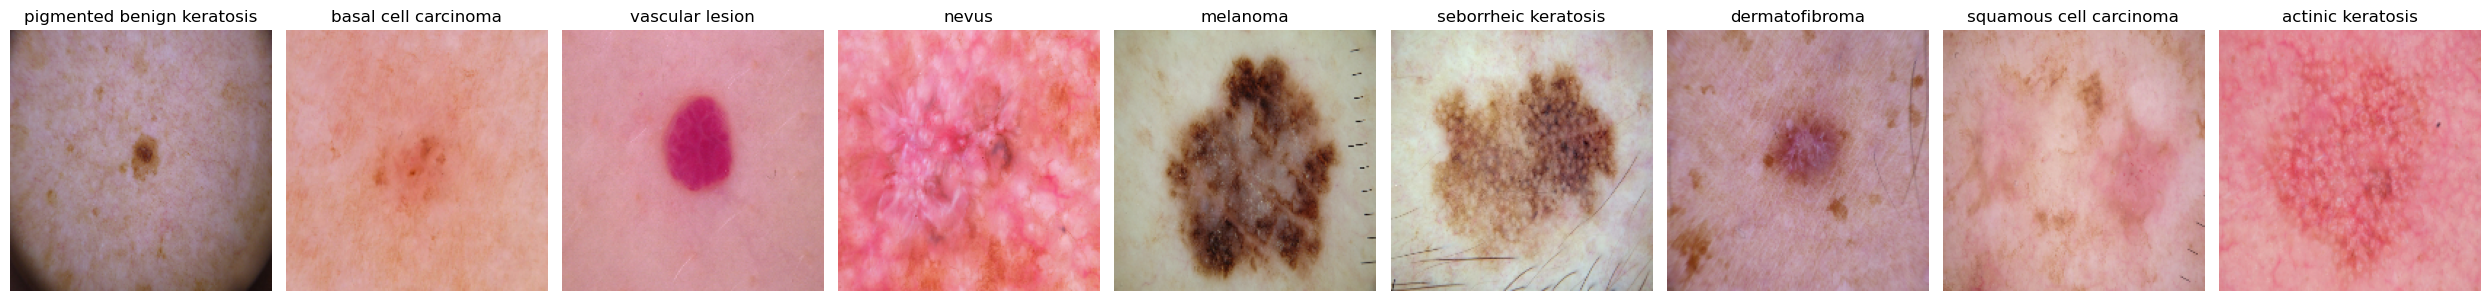

In [30]:
### your code goes here, you can use training or validation data to visualize
class_images = dict()
visited = set()
plt.figure(figsize=(25, 10))
i = 0
for image_batch, label_batch in train_ds:
    for ind, label in enumerate(label_batch.numpy()):
        if label not in visited:
            visited.add(label)
            class_images[class_names[label]] = image_batch[ind].numpy()
            plt.subplot(1, len(class_names), i + 1)
            i += 1
            plt.imshow(image_batch[ind].numpy().astype("uint8"))
            plt.title(class_names[label])
            plt.axis('off')
        if i == 9:
            break
    if i == 9:
        break
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5. Build & Visualize Model - V1

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [44]:
model = Sequential()

In [46]:
# Conv - 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv - 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv - 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# # Flatten
model.add(Flatten())
# Dense
model.add(Dense(512))
model.add(Activation('relu'))
# Softmax
model.add(Dense(9))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [49]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)       

### Train the model

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-09-18 17:33:12.360804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]
2024-09-18 17:33:12.361188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 12.3217 - accuracy: 0.3142

2024-09-18 17:33:34.489201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]
2024-09-18 17:33:34.489340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 24s 381ms/step - loss: 12.3217 - accuracy: 0.3142 - val_loss: 34.7850 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 23s 411ms/step - loss: 1.8092 - accuracy: 0.3968 - val_loss: 25.2909 - val_accuracy: 0.0425
Epoch 3/20
56/56 [==============================] - 24s 421ms/step - loss: 1.4057 - accuracy: 0.5000 - val_loss: 27.8517 - val_accuracy: 0.1834
Epoch 4/20
56/56 [==============================] - 24s 424ms/step - loss: 1.3104 - accuracy: 0.5290 - val_loss: 31.7911 - val_accuracy: 0.1857
Epoch 5/20
56/56 [==============================] - 24s 436ms/step - loss: 1.2389 - accuracy: 0.5647 - val_loss: 23.4537 - val_accuracy: 0.1857
Epoch 6/20
56/56 [==============================] - 24s 423ms/step - loss: 1.1664 - accuracy: 0.5865 - val_loss: 17.5226 - val_accuracy: 0.1879
Epoch 7/20
56/56 [==============================] - 25s 447ms/step - loss: 1.1442 - accuracy: 0.5859 - val_loss: 5.7729 - val_accuracy: 0.2394
Epo

### Visualizing training results

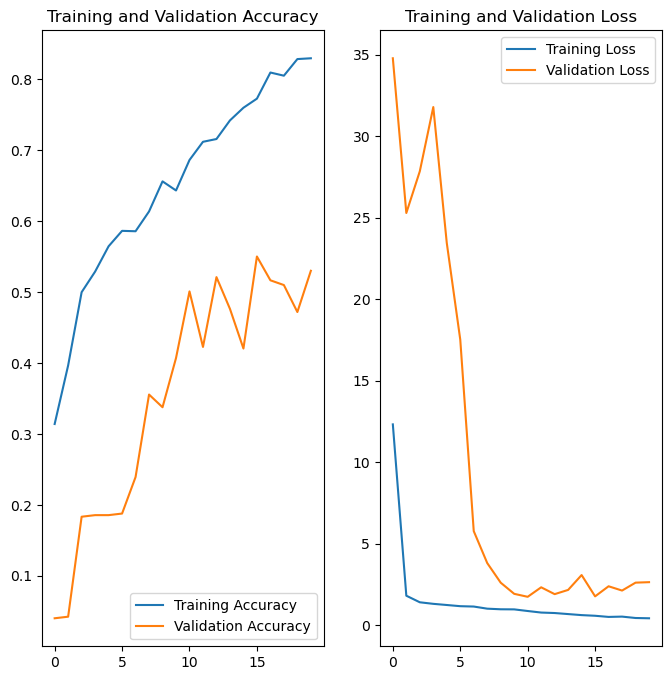

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings after the model fit, see if there is an evidence of model overfit or underfit

<span style="color: green;font-size: 16px;">The model is overfitting as there is large gap between train and val accuracy.</span>

In [59]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
              layers.experimental.preprocessing.RandomFlip('horizontal'),
              layers.experimental.preprocessing.RandomRotation(0.2),
             ])

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.
num_classes = len(class_names)
plt.figure(figsize=(30, 10))
for i, class_name in enumerate(class_images):
    plt.subplot(2, len(class_names), i + 1)
    plt.imshow(class_images[class_name].astype(np.float32).astype("uint8"))
    plt.title(f'Original: {class_name}')
    plt.axis('off')

    augmented_image = data_augmentation(class_images[class_name].astype(np.float32))
    plt.subplot(2, len(class_names), i + 1 + num_classes)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(f'Augmented: {class_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Build & Visualize Model - V2

### Create the model

In [62]:
## You can use Dropout layer if there is evidence of overfitting in your findings
model = Sequential()# Conv - 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Conv - 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Conv - 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# # Flatten
model.add(Flatten())
# Dense
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Softmax
model.add(Dense(9))
model.add(Activation('softmax'))



### Compile the model

In [64]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [66]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 32s 573ms/step - loss: 23.3319 - accuracy: 0.3052 - val_loss: 39.9646 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 35s 616ms/step - loss: 2.8525 - accuracy: 0.2946 - val_loss: 53.3364 - val_accuracy: 0.0403
Epoch 3/20
56/56 [==============================] - 31s 557ms/step - loss: 1.9570 - accuracy: 0.3225 - val_loss: 44.3508 - val_accuracy: 0.0403
Epoch 4/20
56/56 [==============================] - 30s 534ms/step - loss: 1.8444 - accuracy: 0.3488 - val_loss: 25.4587 - val_accuracy: 0.0403
Epoch 5/20
56/56 [==============================] - 30s 533ms/step - loss: 1.8411 - accuracy: 0.3493 - val_loss: 19.3446 - val_accuracy: 0.0403
Epoch 6/20
56/56 [==============================] - 31s 548ms/step - loss: 1.7655 - accuracy: 0.3666 - val_loss: 14.8984 - val_accuracy: 0.0425
Epoch 7/20
56/56 [==============================] - 31s 549ms/step - loss: 1.7121 - accuracy: 0.3996 - val_loss: 9.6993 - val_accuracy:

### Visualizing the results

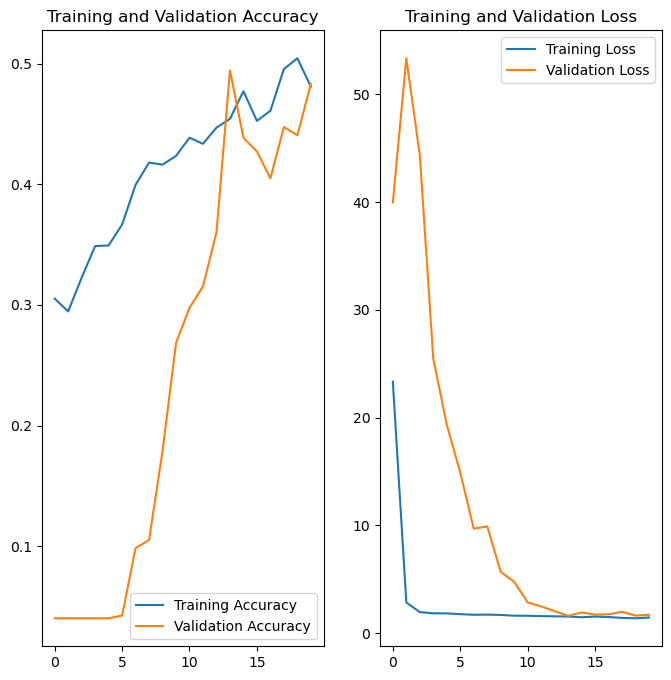

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Questions

Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

<span style="color: green;font-size: 16px;">Overfitting has been fixed after the addition of dropout layers. However, the training accurary has gone down considerably</span>

Find the distribution of classes in the training dataset.

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [72]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dataframe_dict_new = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [73]:
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

Which class has the least number of samples?

<span style="color: green;font-size: 16px;">**seborrheic keratosis** has the least number of samples at 77</span>

Which classes dominate the data in terms proportionate number of samples?

<span style="color: green;font-size: 16px;">**pigmented benign keratosis**, **melanoma**, **basal cell carcinoma**, **nevus**</span>

## 6. Rectify the class imbalance
**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [77]:
for i in class_names:
    p = Augmentor.Pipeline(train_path + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3017FF090>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3017144D0>: 100%|█


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x30156C090>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x301B51D90>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x30158A0D0>: 100%|█


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x301B5FE50>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30158A190>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [79]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [81]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [82]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [83]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [84]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns = ['Path','Label'])

In [85]:
new_df = pd.concat([original_df, df2], ignore_index=True)

In [86]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 7. Build & Visualize Model - V3
Train the model on the data created using Augmentor

In [89]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [91]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [95]:
model = Sequential()
# Conv - 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Conv - 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Conv - 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Conv - 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# # GlobalAveragePooling2D
model.add(GlobalAveragePooling2D())
# Dense
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Softmax
model.add(Dense(9))
model.add(Activation('softmax'))

### Compile your model (Choose optimizer and loss function appropriately)

In [97]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_15 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)       

### Train your model

In [124]:
# epochs = 30
## Your code goes here, use 50 epochs.
epochs = 50
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_weights_only=False, save_best_only=False, save_freq='epoch')
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/50


2024-09-18 17:53:59.996898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5392]
	 [[{{node Placeholder/_4}}]]
2024-09-18 17:53:59.997218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5392]
	 [[{{node Placeholder/_0}}]]


169/169 [==============================] - ETA: 0s - loss: 1.8164 - accuracy: 0.3273

2024-09-18 17:55:15.375330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]
2024-09-18 17:55:15.375466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]


169/169 [==============================] - 81s 478ms/step - loss: 1.8164 - accuracy: 0.3273 - val_loss: 2.8401 - val_accuracy: 0.1418
Epoch 2/50
169/169 [==============================] - 84s 493ms/step - loss: 1.5654 - accuracy: 0.4156 - val_loss: 2.7957 - val_accuracy: 0.1737
Epoch 3/50
169/169 [==============================] - 83s 487ms/step - loss: 1.4565 - accuracy: 0.4449 - val_loss: 2.0717 - val_accuracy: 0.2532
Epoch 4/50
169/169 [==============================] - 85s 501ms/step - loss: 1.4271 - accuracy: 0.4618 - val_loss: 2.3444 - val_accuracy: 0.1849
Epoch 5/50
169/169 [==============================] - 85s 503ms/step - loss: 1.3291 - accuracy: 0.5022 - val_loss: 2.2716 - val_accuracy: 0.2457
Epoch 6/50
169/169 [==============================] - 85s 504ms/step - loss: 1.2618 - accuracy: 0.5200 - val_loss: 1.6721 - val_accuracy: 0.4365
Epoch 7/50
169/169 [==============================] - 85s 503ms/step - loss: 1.2271 - accuracy: 0.5389 - val_loss: 2.5573 - val_accuracy: 0.3

### Visualize the model results

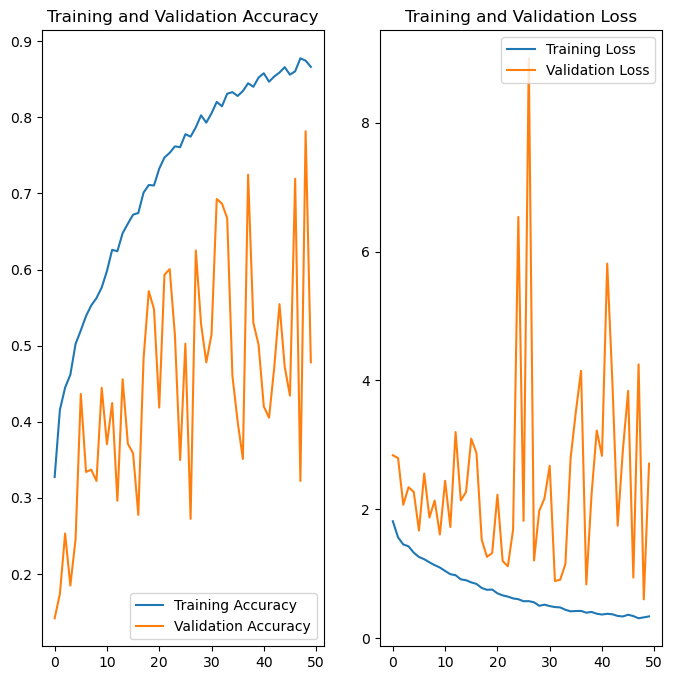

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [155]:
load_model('model_epoch_49.h5').evaluate(test_ds)

4/4 [==============================] - 2s 95ms/step - loss: 3.6663 - accuracy: 0.4407


[3.666287660598755, 0.4406779706478119]

| Model Type | Train Accuracy | Validation Accuracy |
|------------|----------------|---------------|
| Base Model | 83% | 53% |
| Model with Dropout | 48% | 48% |
| Model with Augmentor (49th epoch) | 88% | 78% |

<span style="color: green;font-size: 16px;">From the results above we can conclude that after using Augmentor, the rebalancing helped in increasing the validation accuracy, the final model provides an 88% accuracy on train dataset and 78% on validation dataset. On the test(unseen) dataset, the model returned with an accuracy of 44%</span>